In [0]:
#Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

#Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

#The fautures in these datasets include:

#instant: record index
#dteday : date
#season : season (1:winter, 2:spring, 3:summer, 4:fall)
#yr : year (0: 2011, 1:2012)
#mnth : month ( 1 to 12)
#hr : hour (0 to 23)
#holiday : weather day is holiday or not (extracted from [Web Link])
#weekday : day of the week
#workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
#weathersit :
  #- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  #- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  #- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  #- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
  #- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
  #- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
# hum: Normalized humidity. The values are divided to 100 (max)
# windspeed: Normalized wind speed. The values are divided to 67 (max)
# casual: count of casual users
#registered: count of registered users
#cnt: count of total rental bikes including both casual and registered

#The goal of this project is to use various regression models on the given features in a attempt to determine the best model for this particular dataset

In [0]:
dayPath = "dbfs:/FileStore/tables/day.csv"
day_Df =  spark.read.option('header','true').format("csv").load(dayPath)

day_Df = day_Df.toPandas()
day_Df.head()

Out[4]:

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869,82,1518,1600


In [0]:
day_Df = day_Df.drop(columns=['instant', 'dteday'])

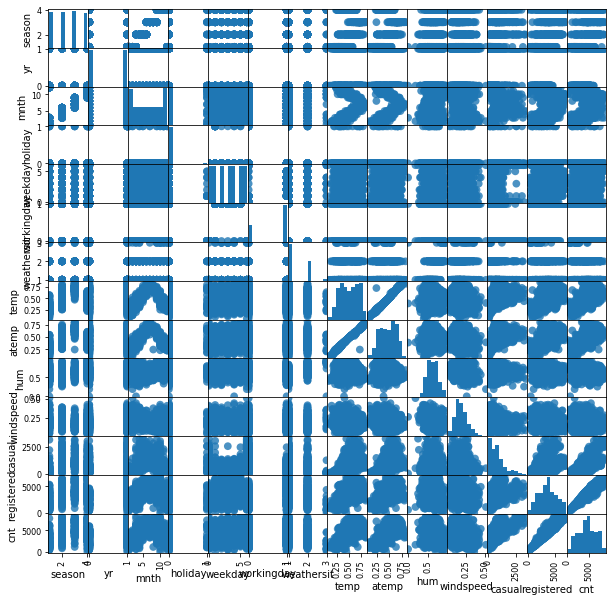

In [0]:
#Visualizing the data
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

df = sqlContext.createDataFrame(day_Df)
df = df.select(*(col(c).cast("float").alias(c) for c in df.columns)).toPandas()
day_PairPlot = pd.plotting.scatter_matrix(df, figsize=(10,10), marker = 'o', hist_kwds = {'bins': 10}, s = 60, alpha = 0.8)

plt.show()

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import col

#Converting features into a singlular Vector and using MinMaxScalar to regularize data
assembler = VectorAssembler().setInputCols(day_Df.columns.values.tolist()[:-1]).setOutputCol("features")
assembler_day_df = sqlContext.createDataFrame(day_Df)
assembler_day_df = assembler_day_df.select(*(col(c).cast("float").alias(c) for c in assembler_day_df.columns))
assembler_day_df = assembler.transform(assembler_day_df)

scalar = MinMaxScaler(inputCol = "features", outputCol= "features_scaled")
scalarModel = scalar.fit(assembler_day_df)
assembler_train_df = scalarModel.transform(assembler_day_df).toPandas()


/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

In [0]:
#Splitting into training and testing datasets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(assembler_train_df, test_size=0.3)
train_df = sqlContext.createDataFrame(train_df)
test_df = sqlContext.createDataFrame(test_df)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Could not convert [4.0,1.0,11.0,1.0,4.0,0.0,1.0,0.3400000035762787,0.35037100315093994,0.5804169774055481,0.052870798856019974,955.0,1470.0] with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Could not convert [4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167001247406,0.5890420079231262,0.8483330011367798,0.11069999635219574,684.0,3946.0] with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

In [0]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression().setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8).setLabelCol("cnt").setFeaturesCol("features_scaled")


lrModel = lr.fit(train_df)
lrTest = lrModel.transform(test_df)
lrTest.toPandas().head()


/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[9]:

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,features,features_scaled,prediction
0,4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167,0.589042,0.848333,0.110700,684.0,3946.0,4630.0,"[4.0, 0.0, 9.0, 0.0, 1.0, 1.0, 2.0, 0.64916700...","[1.0, 0.0, 0.7272727272727273, 0.0, 0.16666666...",4650.286031
1,1.0,0.0,3.0,0.0,4.0,1.0,1.0,0.198333,0.200133,0.318333,0.225754,123.0,1562.0,1685.0,"[1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 0.19833299...","[0.0, 0.0, 0.18181818181818182, 0.0, 0.6666666...",1738.155426
2,1.0,0.0,3.0,0.0,6.0,0.0,2.0,0.384167,0.378779,0.789167,0.251871,640.0,1437.0,2077.0,"[1.0, 0.0, 3.0, 0.0, 6.0, 0.0, 2.0, 0.38416698...","[0.0, 0.0, 0.18181818181818182, 0.0, 1.0, 0.0,...",1949.809589
3,4.0,0.0,12.0,0.0,4.0,1.0,1.0,0.312500,0.305554,0.524583,0.220158,182.0,3545.0,3727.0,"[4.0, 0.0, 12.0, 0.0, 4.0, 1.0, 1.0, 0.3125, 0...","[1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, ...",3697.684359
4,2.0,0.0,6.0,0.0,0.0,0.0,1.0,0.692500,0.643325,0.747917,0.163567,1467.0,2993.0,4460.0,"[2.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.69249999...","[0.3333333333333333, 0.0, 0.4545454545454546, ...",4346.450267


In [0]:
summary = lrModel.summary
summary.residuals.show()
print (summary.totalIterations)
print (summary.objectiveHistory)
print (summary.rootMeanSquaredError)
print (summary.r2)

+-------------------+
 residuals|
+-------------------+
-208.24391693786401|
 59.75468202598404|
 -81.276902671897|
 100.40490994033507|
 77.25835284833647|
 -5.453435854803502|
 59.02109962090526|
 29.770062081634023|
 92.77537039134859|
 35.44863925300979|
 -7.635779644911963|
 29.397231409522647|
 -38.18363395188749|
-131.93741779753236|
 -4.337408491091082|
 -54.22621068791159|
 -4.760869296269448|
 -34.94251957621782|
-28.383731738754022|
 5.594415335678605|
+-------------------+
only showing top 20 rows

11
[0.5, 0.3414168213977246, 0.11723474120525573, 0.027607770556392887, 0.022571924627976442, 0.009758329761347656, 0.0037551867116821427, 0.002738871785964186, 0.0014345027969576783, 0.0011717533892294015, 0.000985853543858264]
77.36730464324557
0.9983849088170516

In [0]:
#Poission Regression Model
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression().setFamily("Poisson").setLink("Log").setMaxIter(10).setRegParam(0.3).setLinkPredictionCol("linkOut").setFeaturesCol("features_scaled").setLabelCol("cnt")

glrModel = glr.fit(train_df)
glrTest = glrModel.transform(test_df)
glrTest.toPandas().head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[11]:

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,features,features_scaled,linkOut,prediction
0,4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167,0.589042,0.848333,0.110700,684.0,3946.0,4630.0,"[4.0, 0.0, 9.0, 0.0, 1.0, 1.0, 2.0, 0.64916700...","[1.0, 0.0, 0.7272727272727273, 0.0, 0.16666666...",8.384734,4379.695501
1,1.0,0.0,3.0,0.0,4.0,1.0,1.0,0.198333,0.200133,0.318333,0.225754,123.0,1562.0,1685.0,"[1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 0.19833299...","[0.0, 0.0, 0.18181818181818182, 0.0, 0.6666666...",8.094826,3277.465748
2,1.0,0.0,3.0,0.0,6.0,0.0,2.0,0.384167,0.378779,0.789167,0.251871,640.0,1437.0,2077.0,"[1.0, 0.0, 3.0, 0.0, 6.0, 0.0, 2.0, 0.38416698...","[0.0, 0.0, 0.18181818181818182, 0.0, 1.0, 0.0,...",8.098992,3291.148207
3,4.0,0.0,12.0,0.0,4.0,1.0,1.0,0.312500,0.305554,0.524583,0.220158,182.0,3545.0,3727.0,"[4.0, 0.0, 12.0, 0.0, 4.0, 1.0, 1.0, 0.3125, 0...","[1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, ...",8.318670,4099.704843
4,2.0,0.0,6.0,0.0,0.0,0.0,1.0,0.692500,0.643325,0.747917,0.163567,1467.0,2993.0,4460.0,"[2.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.69249999...","[0.3333333333333333, 0.0, 0.4545454545454546, ...",8.338113,4180.192564


In [0]:
summary = glrModel.summary
print(summary.residuals)
print (summary.coefficientStandardErrors)
print (summary.predictions)

<bound method GeneralizedLinearRegressionSummary.residuals of Coefficients:
 Feature Estimate Std Error T Value P Value
 (Intercept) 7.9872 0.0019 4301.9630 0.0000
 features_scaled_0 0.0980 0.0010 94.1401 0.0000
 features_scaled_1 0.1845 0.0009 203.8910 0.0000
 features_scaled_2 0.0496 0.0011 45.6724 0.0000
 features_scaled_3 -0.0173 0.0012 -14.8779 0.0000
 features_scaled_4 0.0120 0.0010 11.6771 0.0000
 features_scaled_5 0.0227 0.0009 24.4348 0.0000
 features_scaled_6 -0.0799 0.0011 -73.6573 0.0000
 features_scaled_7 0.1228 0.0011 108.6725 0.0000
 features_scaled_8 0.1160 0.0011 101.8149 0.0000
 features_scaled_9 -0.0145 0.0012 -12.3831 0.0000
features_scaled_10 -0.0292 0.0012 -25.1260 0.0000
features_scaled_11 0.1256 0.0011 109.7029 0.0000
features_scaled_12 0.1829 0.0011 160.1486 0.0000

(Dispersion parameter for poisson family taken to be 1.0000)
 Null deviance: 466073.4941 on 497 degrees of freedom
Residual deviance: 211236.1730 on 497 degrees of freedom
AIC: 216433.9385>
[0.0010404877208243957, 0.0009048470880123485, 0.0010856496820874195, 0.0011614596141076568, 0.0010242540097711904, 0.0009276993198407054, 0.0010850315565208953, 0.0011298199308686944, 0.0011395668338658673, 0.0011695604998152634, 0.001160476450324089, 0.0011447939528530554, 0.0011419874580397848, 0.0018566459983751884]
DataFrame[season: double, yr: double, mnth: double, holiday: double, weekday: double, workingday: double, weathersit: double, temp: double, atemp: double, hum: double, windspeed: double, casual: double, registered: double, cnt: double, features: vector, features_scaled: vector, linkOut: double, prediction: double]

In [0]:
#Gamma Regression Model
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression().setFamily("Gamma").setLink("Inverse").setMaxIter(10).setRegParam(0.3).setLinkPredictionCol("linkOut").setFeaturesCol("features_scaled").setLabelCol("cnt")

glrModel = glr.fit(train_df)
glrTest = glrModel.transform(test_df)
glrTest.toPandas().head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[13]:

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,features,features_scaled,linkOut,prediction
0,4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167,0.589042,0.848333,0.110700,684.0,3946.0,4630.0,"[4.0, 0.0, 9.0, 0.0, 1.0, 1.0, 2.0, 0.64916700...","[1.0, 0.0, 0.7272727272727273, 0.0, 0.16666666...",0.000231,4332.293700
1,1.0,0.0,3.0,0.0,4.0,1.0,1.0,0.198333,0.200133,0.318333,0.225754,123.0,1562.0,1685.0,"[1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 0.19833299...","[0.0, 0.0, 0.18181818181818182, 0.0, 0.6666666...",0.000295,3391.247058
2,1.0,0.0,3.0,0.0,6.0,0.0,2.0,0.384167,0.378779,0.789167,0.251871,640.0,1437.0,2077.0,"[1.0, 0.0, 3.0, 0.0, 6.0, 0.0, 2.0, 0.38416698...","[0.0, 0.0, 0.18181818181818182, 0.0, 1.0, 0.0,...",0.000294,3402.938297
3,4.0,0.0,12.0,0.0,4.0,1.0,1.0,0.312500,0.305554,0.524583,0.220158,182.0,3545.0,3727.0,"[4.0, 0.0, 12.0, 0.0, 4.0, 1.0, 1.0, 0.3125, 0...","[1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, ...",0.000245,4075.478958
4,2.0,0.0,6.0,0.0,0.0,0.0,1.0,0.692500,0.643325,0.747917,0.163567,1467.0,2993.0,4460.0,"[2.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.69249999...","[0.3333333333333333, 0.0, 0.4545454545454546, ...",0.000241,4143.514550


In [0]:
summary = glrModel.summary
print(summary)

Coefficients:
 Feature Estimate Std Error T Value P Value
 (Intercept) 0.0003 0.0000 37.3721 0.0000
 features_scaled_0 0.0000 0.0000 -4.6432 0.0000
 features_scaled_1 0.0000 0.0000 -9.8306 0.0000
 features_scaled_2 0.0000 0.0000 -2.3080 0.0214
 features_scaled_3 0.0000 0.0000 0.7100 0.4780
 features_scaled_4 0.0000 0.0000 -0.5071 0.6123
 features_scaled_5 0.0000 0.0000 -1.1783 0.2392
 features_scaled_6 0.0000 0.0000 3.5480 0.0004
 features_scaled_7 0.0000 0.0000 -5.3051 0.0000
 features_scaled_8 0.0000 0.0000 -4.9753 0.0000
 features_scaled_9 0.0000 0.0000 0.5742 0.5661
features_scaled_10 0.0000 0.0000 1.2143 0.2252
features_scaled_11 0.0000 0.0000 -5.3201 0.0000
features_scaled_12 0.0000 0.0000 -7.7552 0.0000

(Dispersion parameter for gamma family taken to be 0.0937)
 Null deviance: 135.1327 on 497 degrees of freedom
Residual deviance: 79.2035 on 497 degrees of freedom
AIC: 9001.8163

In [0]:
#Tweedie Regression Model
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression().setFamily("Tweedie").setMaxIter(10).setRegParam(0.3).setLinkPredictionCol("linkOut").setFeaturesCol("features_scaled").setLabelCol("cnt")

glrModel = glr.fit(train_df)
glrTest = glrModel.transform(test_df)
glrTest.toPandas().head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[15]:

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,features,features_scaled,linkOut,prediction
0,4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167,0.589042,0.848333,0.110700,684.0,3946.0,4630.0,"[4.0, 0.0, 9.0, 0.0, 1.0, 1.0, 2.0, 0.64916700...","[1.0, 0.0, 0.7272727272727273, 0.0, 0.16666666...",4629.801570,4629.801570
1,1.0,0.0,3.0,0.0,4.0,1.0,1.0,0.198333,0.200133,0.318333,0.225754,123.0,1562.0,1685.0,"[1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 0.19833299...","[0.0, 0.0, 0.18181818181818182, 0.0, 0.6666666...",1685.250572,1685.250572
2,1.0,0.0,3.0,0.0,6.0,0.0,2.0,0.384167,0.378779,0.789167,0.251871,640.0,1437.0,2077.0,"[1.0, 0.0, 3.0, 0.0, 6.0, 0.0, 2.0, 0.38416698...","[0.0, 0.0, 0.18181818181818182, 0.0, 1.0, 0.0,...",2076.578496,2076.578496
3,4.0,0.0,12.0,0.0,4.0,1.0,1.0,0.312500,0.305554,0.524583,0.220158,182.0,3545.0,3727.0,"[4.0, 0.0, 12.0, 0.0, 4.0, 1.0, 1.0, 0.3125, 0...","[1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, ...",3726.784547,3726.784547
4,2.0,0.0,6.0,0.0,0.0,0.0,1.0,0.692500,0.643325,0.747917,0.163567,1467.0,2993.0,4460.0,"[2.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.69249999...","[0.3333333333333333, 0.0, 0.4545454545454546, ...",4459.743224,4459.743224


In [0]:
summary = glrModel.summary
print(summary)

Coefficients:
 Feature Estimate Std Error T Value P Value
 (Intercept) 22.7771 0.1819 125.2359 0.0000
 features_scaled_0 0.9847 0.1331 7.3959 0.0000
 features_scaled_1 1.2959 0.0755 17.1709 0.0000
 features_scaled_2 -0.2265 0.1440 -1.5734 0.1163
 features_scaled_3 -0.4416 0.1594 -2.7707 0.0058
 features_scaled_4 0.1637 0.0720 2.2757 0.0233
 features_scaled_5 0.6085 0.0890 6.8383 0.0000
 features_scaled_6 -0.8294 0.1184 -7.0028 0.0000
 features_scaled_7 0.5838 0.7319 0.7976 0.4255
 features_scaled_8 1.4666 0.7860 1.8659 0.0626
 features_scaled_9 -0.4186 0.2211 -1.8930 0.0589
features_scaled_10 -0.6006 0.1668 -3.6006 0.0003
features_scaled_11 3407.7369 0.2216 15375.3826 0.0000
features_scaled_12 6920.8833 0.2459 28149.8042 0.0000

(Dispersion parameter for gaussian family taken to be 0.2908)
Null deviance: 1893820388.7671 on 497 degrees of freedom
 Residual deviance: 144.5197 on 497 degrees of freedom
AIC: 834.7858

In [0]:
#Decision Tree Regression Model
from pyspark.ml.regression import DecisionTreeRegressor
dtr = DecisionTreeRegressor().setFeaturesCol("features_scaled").setLabelCol("cnt").setMaxDepth(4).setMaxBins(30)
dtModel = dtr.fit(train_df)
dtTest = dtModel.transform(test_df).toPandas()

dtTest.head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[17]:

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,features,features_scaled,prediction
0,4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167,0.589042,0.848333,0.110700,684.0,3946.0,4630.0,"[4.0, 0.0, 9.0, 0.0, 1.0, 1.0, 2.0, 0.64916700...","[1.0, 0.0, 0.7272727272727273, 0.0, 0.16666666...",5014.452830
1,1.0,0.0,3.0,0.0,4.0,1.0,1.0,0.198333,0.200133,0.318333,0.225754,123.0,1562.0,1685.0,"[1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 0.19833299...","[0.0, 0.0, 0.18181818181818182, 0.0, 0.6666666...",1991.145161
2,1.0,0.0,3.0,0.0,6.0,0.0,2.0,0.384167,0.378779,0.789167,0.251871,640.0,1437.0,2077.0,"[1.0, 0.0, 3.0, 0.0, 6.0, 0.0, 2.0, 0.38416698...","[0.0, 0.0, 0.18181818181818182, 0.0, 1.0, 0.0,...",2990.695652
3,4.0,0.0,12.0,0.0,4.0,1.0,1.0,0.312500,0.305554,0.524583,0.220158,182.0,3545.0,3727.0,"[4.0, 0.0, 12.0, 0.0, 4.0, 1.0, 1.0, 0.3125, 0...","[1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, ...",4242.816901
4,2.0,0.0,6.0,0.0,0.0,0.0,1.0,0.692500,0.643325,0.747917,0.163567,1467.0,2993.0,4460.0,"[2.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.69249999...","[0.3333333333333333, 0.0, 0.4545454545454546, ...",4597.312500


In [0]:
from pyspark.mllib.evaluation import RegressionMetrics
dtTest = sqlContext.createDataFrame(dtTest)
out = dtTest.select("cnt","prediction").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = RegressionMetrics(out)

print ("MSE: " + str(metrics.meanSquaredError))
print ("RMSE: " + str(metrics.rootMeanSquaredError))
print ("R-squared: " + str(metrics.r2))
print ("MAE: " + str(metrics.meanAbsoluteError))
print ("Explained variance: " + str(metrics.explainedVariance))

/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Could not convert [4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167001247406,0.5890420079231262,0.8483330011367798,0.11069999635219574,684.0,3946.0] with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
MSE: 157230.9466043996
RMSE: 396.52357635378957
R-squared: 0.9573336652613386
MAE: 318.19963867255655
Explained variance: 3845117.4194545746

In [0]:
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor().setFeaturesCol("features_scaled").setLabelCol("cnt").setMaxBins(30).setMaxDepth(4).setNumTrees(20)
rfrModel = rfr.fit(train_df)
rfrTest = rfrModel.transform(test_df).toPandas()

rfrTest.head()

Out[21]:

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,features,features_scaled,prediction
0,4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167,0.589042,0.848333,0.110700,684.0,3946.0,4630.0,"[4.0, 0.0, 9.0, 0.0, 1.0, 1.0, 2.0, 0.64916700...","[1.0, 0.0, 0.7272727272727273, 0.0, 0.16666666...",4648.820876
1,1.0,0.0,3.0,0.0,4.0,1.0,1.0,0.198333,0.200133,0.318333,0.225754,123.0,1562.0,1685.0,"[1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 0.19833299...","[0.0, 0.0, 0.18181818181818182, 0.0, 0.6666666...",1634.905945
2,1.0,0.0,3.0,0.0,6.0,0.0,2.0,0.384167,0.378779,0.789167,0.251871,640.0,1437.0,2077.0,"[1.0, 0.0, 3.0, 0.0, 6.0, 0.0, 2.0, 0.38416698...","[0.0, 0.0, 0.18181818181818182, 0.0, 1.0, 0.0,...",2461.501271
3,4.0,0.0,12.0,0.0,4.0,1.0,1.0,0.312500,0.305554,0.524583,0.220158,182.0,3545.0,3727.0,"[4.0, 0.0, 12.0, 0.0, 4.0, 1.0, 1.0, 0.3125, 0...","[1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, ...",3630.674811
4,2.0,0.0,6.0,0.0,0.0,0.0,1.0,0.692500,0.643325,0.747917,0.163567,1467.0,2993.0,4460.0,"[2.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.69249999...","[0.3333333333333333, 0.0, 0.4545454545454546, ...",4490.962601


In [0]:
from pyspark.mllib.evaluation import RegressionMetrics
rfrTest = sqlContext.createDataFrame(rfrTest)
out = dtTest.select("cnt","prediction").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = RegressionMetrics(out)

print ("MSE: " + str(metrics.meanSquaredError))
print ("RMSE: " + str(metrics.rootMeanSquaredError))
print ("R-squared: " + str(metrics.r2))
print ("MAE: " + str(metrics.meanAbsoluteError))
print ("Explained variance: " + str(metrics.explainedVariance))

/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Could not convert [4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167001247406,0.5890420079231262,0.8483330011367798,0.11069999635219574,684.0,3946.0] with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
MSE: 157230.9466043996
RMSE: 396.52357635378957
R-squared: 0.9573336652613386
MAE: 318.19963867255655
Explained variance: 3845117.4194545834

In [0]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor().setFeaturesCol("features_scaled").setLabelCol("cnt").setMaxBins(30).setMaxDepth(4)
gbtModel = gbt.fit(train_df)
gbtTest = gbtModel.transform(test_df).toPandas()

gbtTest.head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[24]:

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,features,features_scaled,prediction
0,4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167,0.589042,0.848333,0.110700,684.0,3946.0,4630.0,"[4.0, 0.0, 9.0, 0.0, 1.0, 1.0, 2.0, 0.64916700...","[1.0, 0.0, 0.7272727272727273, 0.0, 0.16666666...",4893.956972
1,1.0,0.0,3.0,0.0,4.0,1.0,1.0,0.198333,0.200133,0.318333,0.225754,123.0,1562.0,1685.0,"[1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 0.19833299...","[0.0, 0.0, 0.18181818181818182, 0.0, 0.6666666...",1737.887667
2,1.0,0.0,3.0,0.0,6.0,0.0,2.0,0.384167,0.378779,0.789167,0.251871,640.0,1437.0,2077.0,"[1.0, 0.0, 3.0, 0.0, 6.0, 0.0, 2.0, 0.38416698...","[0.0, 0.0, 0.18181818181818182, 0.0, 1.0, 0.0,...",2858.837509
3,4.0,0.0,12.0,0.0,4.0,1.0,1.0,0.312500,0.305554,0.524583,0.220158,182.0,3545.0,3727.0,"[4.0, 0.0, 12.0, 0.0, 4.0, 1.0, 1.0, 0.3125, 0...","[1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, ...",3814.502166
4,2.0,0.0,6.0,0.0,0.0,0.0,1.0,0.692500,0.643325,0.747917,0.163567,1467.0,2993.0,4460.0,"[2.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.69249999...","[0.3333333333333333, 0.0, 0.4545454545454546, ...",4568.248286


In [0]:
from pyspark.mllib.evaluation import RegressionMetrics
gbtTest = sqlContext.createDataFrame(gbtTest)
out = dtTest.select("cnt","prediction").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = RegressionMetrics(out)

print ("MSE: " + str(metrics.meanSquaredError))
print ("RMSE: " + str(metrics.rootMeanSquaredError))
print ("R-squared: " + str(metrics.r2))
print ("MAE: " + str(metrics.meanAbsoluteError))
print ("Explained variance: " + str(metrics.explainedVariance))

/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Could not convert [4.0,0.0,9.0,0.0,1.0,1.0,2.0,0.649167001247406,0.5890420079231262,0.8483330011367798,0.11069999635219574,684.0,3946.0] with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
MSE: 157230.9466043996
RMSE: 396.52357635378957
R-squared: 0.9573336652613386
MAE: 318.19963867255655
Explained variance: 3845117.4194545834